# Spettro del Rubino

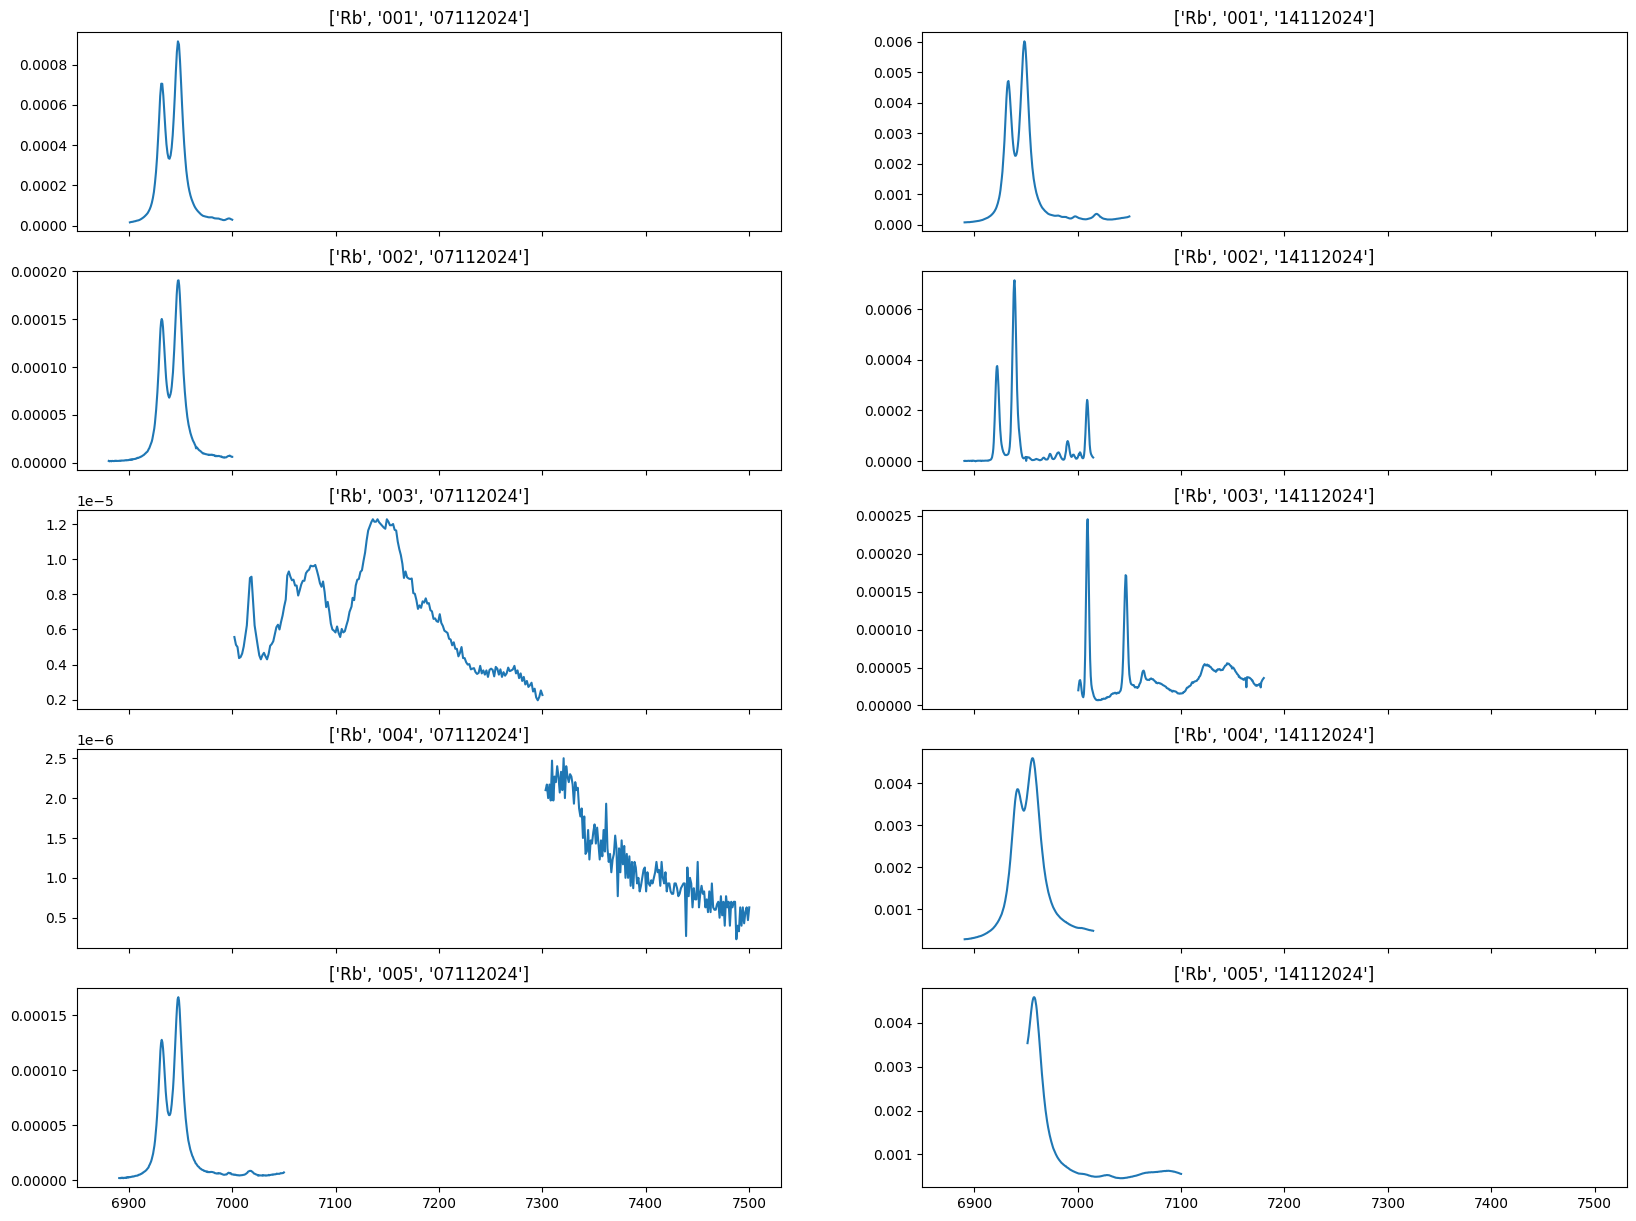

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast

# Load data
files = utils.getFiles('Raw_Data\\Rubidium_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)
# A quick look at the data
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(20, 15))
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    ax[ i % 5, int(i / 5)].ticklabel_format(axis='y', style='sci')
    ax[ i % 5, int(i / 5)].plot(row['wl'], row['mean'])
    ax[ i % 5, int(i / 5)].set_title([meta.get(key) for key in ['type', 'id', 'date',]])